# Homework Solution 8

Ming Hong (mh4286@nyu.edu）

In [1]:
%pylab inline
import math, time, fmt
from numba import jit ## requires numba packages, you need to install it for this HW
from scipy.stats import norm
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## (Extra Credit) Problem 1

Python is an interpretive language, however, there are tools that can compile Python code on the fly and allows almost native execution speed in some cases. One of such tools is the numba just in time (JIT) compiler. The following is an implementation of the fast inverse normal CDF function, which can be used to convert uniform random numbers to normal random numbers. Note the @jit declaration in the code, which activates the numba JIT compiler for the following python function.

In [2]:
@jit
def ltqnorm( p ):
    """
    Modified from the author's original perl code (original comments follow below)
    by dfield@yahoo-inc.com.  May 3, 2004.

    Lower tail quantile for standard normal distribution function.

    This function returns an approximation of the inverse cumulative
    standard normal distribution function.  I.e., given P, it returns
    an approximation to the X satisfying P = Pr{Z <= X} where Z is a
    random variable from the standard normal distribution.

    The algorithm uses a minimax approximation by rational functions
    and the result has a relative error whose absolute value is less
    than 1.15e-9.

    Author:      Peter John Acklam
    Time-stamp:  2000-07-19 18:26:14
    E-mail:      pjacklam@online.no
    WWW URL:     http://home.online.no/~pjacklam
    """

    if p <= 0 or p >= 1:
        return np.nan

    # Coefficients in rational approximations.
    a = (-3.969683028665376e+01,  2.209460984245205e+02, \
         -2.759285104469687e+02,  1.383577518672690e+02, \
         -3.066479806614716e+01,  2.506628277459239e+00)
    b = (-5.447609879822406e+01,  1.615858368580409e+02, \
         -1.556989798598866e+02,  6.680131188771972e+01, \
         -1.328068155288572e+01 )
    c = (-7.784894002430293e-03, -3.223964580411365e-01, \
         -2.400758277161838e+00, -2.549732539343734e+00, \
          4.374664141464968e+00,  2.938163982698783e+00)
    d = ( 7.784695709041462e-03,  3.224671290700398e-01, \
          2.445134137142996e+00,  3.754408661907416e+00)

    # Define break-points.
    plow  = 0.02425
    phigh = 1 - plow

    # Rational approximation for lower region:
    if p < plow:
       q  = math.sqrt(-2*math.log(p))
       return (((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
               ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)

    # Rational approximation for upper region:
    if phigh < p:
       q  = math.sqrt(-2*math.log(1-p))
       return -(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
                ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)

    # Rational approximation for central region:
    q = p - 0.5
    r = q*q
    return (((((a[0]*r+a[1])*r+a[2])*r+a[3])*r+a[4])*r+a[5])*q / \
           (((((b[0]*r+b[1])*r+b[2])*r+b[3])*r+b[4])*r+1)
    

@jit
def ninv_vec(xs) :
    return np.array(map(ltqnorm, xs))

1. use the above code to inverse 1 million equally sampled numbers btw 0 and 1, compare it with the build in scipy.stat.norm.ppf function to verify that the absolute error is on the order of $10^{-9}$. Is there a different btw the first run and the subsequent runs with the @jit flag on?
2. remove the @jit flag, and repeat 1, note the speed difference.

### Solution

**1)** The following graph plots the absolute errors of the normal inverse function with respect to the built-in ```scipy.stats.norm.ppf()``` function. It can be seen from Figure 1 that all the errors are less than $10^{-9}$. 

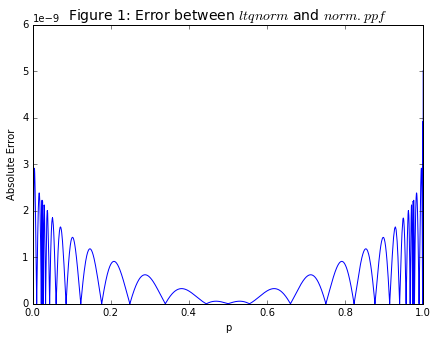

In [3]:
P = np.arange(1./1e6,1,1./1e6);
times = np.zeros(5)

for i in range(0,5):
    t1 = time.clock()
    X = ninv_vec(P);
    t2 = time.clock()
    times[i] = float(t2 - t1)

X_sp = norm.ppf(P);
diff = np.abs(X-X_sp);
plt.figure(figsize=[7,5])
plt.plot(P,diff)
plt.xlabel('p')
plt.ylabel('Absolute Error')
plt.title('Figure 1: Error between $ltqnorm$ and $norm.ppf$', fontsize=14)
plt.show()

The running times are listed in the table below. It is clear that after the first run, subsequent runs take only about half of the time of the first run with the @jit flat on.

In [4]:
# Running times for the 1st and subsequent runs
fmt.displayDF(pd.DataFrame((times.T), index=['1','2','3','4','5'], columns=['Time (sec)']).T, "3f")

,1,2,3,4,5
Time (sec),0.560,0.279,0.270,0.269,0.274


**2)** When turning the @jit flag off, all the runs take substantially longer time.

In [5]:
def ltqnorm2( p ):
    if p <= 0 or p >= 1:
        return np.nan

    # Coefficients in rational approximations.
    a = (-3.969683028665376e+01,  2.209460984245205e+02, \
         -2.759285104469687e+02,  1.383577518672690e+02, \
         -3.066479806614716e+01,  2.506628277459239e+00)
    b = (-5.447609879822406e+01,  1.615858368580409e+02, \
         -1.556989798598866e+02,  6.680131188771972e+01, \
         -1.328068155288572e+01 )
    c = (-7.784894002430293e-03, -3.223964580411365e-01, \
         -2.400758277161838e+00, -2.549732539343734e+00, \
          4.374664141464968e+00,  2.938163982698783e+00)
    d = ( 7.784695709041462e-03,  3.224671290700398e-01, \
          2.445134137142996e+00,  3.754408661907416e+00)

    # Define break-points.
    plow  = 0.02425
    phigh = 1 - plow

    # Rational approximation for lower region:
    if p < plow:
       q  = math.sqrt(-2*math.log(p))
       return (((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
               ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)

    # Rational approximation for upper region:
    if phigh < p:
       q  = math.sqrt(-2*math.log(1-p))
       return -(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
                ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)

    # Rational approximation for central region:
    q = p - 0.5
    r = q*q
    return (((((a[0]*r+a[1])*r+a[2])*r+a[3])*r+a[4])*r+a[5])*q / \
           (((((b[0]*r+b[1])*r+b[2])*r+b[3])*r+b[4])*r+1)
    
def ninv_vec2(xs) :
    return np.array(map(ltqnorm2, xs))

for i in range(0,5):
    t1 = time.clock()
    X = ninv_vec2(P);
    t2 = time.clock()
    times[i] = float(t2 - t1)
    
fmt.displayDF(pd.DataFrame((times.T), index=['1','2','3','4','5'], columns=['Time (sec)']).T, "3f")

,1,2,3,4,5
Time (sec),3.580,3.614,3.688,3.572,3.655


## Problem 2

This problem explores the expoential log Euler and the Milstein scheme on the following CIR process:

$$ d r(t) = \kappa (\bar{r} - r(t)) dt + \sigma \sqrt{r(t)} dw(t)$$

with: $\kappa = 0.1, \bar{r} = 0.03, \sigma = 0.05, r(0) = 0.01$, all the parameters are annualized.

It was taught in many text book that when sampling the above CIR process, one way to avoid the negative value is to flip the sign of the random normal random number if it would lead to negative $r$ values in the next simulation step. This makes the $r(t)=0$ a reflective boundary.

1. what is the analytical expression of  $\mathbb E [r(t)]$, you can cite a reference to answer this question, but it is useful for you to understand how it was derived (no need to write it in your answers).
2. implement the Euler discretizaitaon with the reflective boundary, run the simulation to compute the average of $r(10Y)$ with reflective boundary using different time sample step sizes, and plot the bias at 10Y as a function of the time sample step sizes.
3. repeat 2, but using the log Euler sampling and comment on your results
4. repeat, but use the Milstein scheme
4. draw a few paths from all three methods using the same set random numbers and show that they are indeed path-wise equivalent for paths that do not hit zero (path wise equivalence guaranteed by Ito's lemma); also show a few paths that have different behaviours near $r(t) = 0$.

Hint: in the log Euler step, the log(r(t)) can become very negative, leading to a underflow to 0. in the exp() function. You can apply a reflective cap/floor on the log(r(t)) to avoid the under flow problem. 

### Solution

**1)** Given the SDE $ d r(t) = \kappa (\bar{r} - r(t)) dt + \sigma \sqrt{r(t)} dw(t)$, we have

$$ r(t) - r(0) = \int_0^t \kappa(\bar{r}-r(u)) du + \int_0^t \sigma \sqrt{r(u)} dw(u) $$

Hence, the analytical expression of the expectation can be obtained as

$$ \begin{align} \mathbb E[r(t)] & = r(0) + \int_0^t \kappa(\bar{r}-\mathbb E[r(u)]) du + \mathbb E \left[\int_0^t \sigma \sqrt{r(u)} dw(u) \right] \\
& = r(0)  e^{-\kappa t} + \bar{r} (1-e^{-\kappa t}) \end{align}$$

**2) - 4)** The three schemes are implemented in the following code to compute the average of $r(10Y)$. In Figure 2.1, the bias at 10Y as a function of step size ($\delta t$) is plotted for each scheme. The number of steps is varied from 40 ($\delta t = 0.25$) to 1,000 ($\delta t = 0.01$).

More specifically, in the Euler scheme, a reflective boundary at $r=0$ is added to ensure no negative values would appear.

In the Log-Euler scheme, we apply a transformation $y(t) = \log(r(t))$:

$$\small dy(t) = \frac{1}{r(t)}\left(\kappa(\bar r - r(t)) - \frac{\sigma^2}{2} \right) dt + \frac{\sigma}{\sqrt{r(t)}}dw(t) $$

Here a floor at $y=-10$ is implemented so that $y(t)$ can never get below -10. This avoids the underflow problem when taking the exponential of $y(t)$ in order to get $r(t)$. Since in reality the minimal increment of interest rates hardly gets below 0.01%, the floor is chosen as $\text{floor}(\log(0.01\%)) = -10 $.

However, for large step sizes, there is another problem. Even if $y(t)$ has a floor, the resulting $r(t)$ could still get so small that when $\delta t$ is large enough (say, $\delta t = 1 \text{ or } 0.5$), the first term in the discretized Log-Euler scheme, $ \frac{1}{r(t)}\left(\kappa(\bar r - r(t)) - \frac{\sigma^2}{2} \right) \delta t$, may increase $y$ to a value much greater than 1 in the next step, which will make $r(t)$ explode. This issue would appear if a sufficient number of sample paths are generated. One way to circumvent the problem is to have the number of steps large enough (so that $\delta t$ is small). 

Finally, in the Milstein scheme, a reflective boundary at $r=0$ is imeplemented as with the Euler scheme. In addition, a correction term $ \frac{1}{2} \sigma \dot \sigma (\tilde z^2 - 1) \delta t $ is added to the increment $\delta r$, where $\dot\sigma = \frac{1}{2} r(t)^{-0.5}\sigma$.

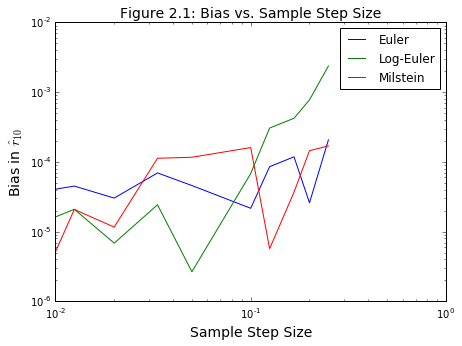

In [37]:
k = 0.1
r_bar = 0.03
sigma = 0.05
r0 = 0.01
T = 10.
r10 = r0*np.exp(-k*T)+r_bar*(1-np.exp(-k*T)) # expected value of r(10)

# Euler

def CIR_Euler(k, r_bar, sigma, r0, T, N=1000, M=50000, eps=[]):  
    if np.size(eps) == 0:
        eps = np.random.normal(size=[N,M])
    else:
        N = int(np.size(eps,0))
        M = int(np.size(eps,1))
    
    dt = T/N
    r = np.zeros([N+1,M])
    r[0,:] = r0
    
    eps = eps * np.sqrt(dt)
    flag =np.zeros(M)
    
    for n in np.arange(1,N+1):
        r[n,:] = r[n-1,:] + k*(np.tile(r_bar,(1,M))-r[n-1,:])*dt + sigma*np.sqrt(r[n-1,:])*eps[n-1,:]
        neg_ind = np.where(r[n,:] < 0)
        flag[neg_ind] = 1
        eps[n-1,neg_ind] = - eps[n-1,neg_ind]
        r[n,:] = r[n-1,:] + k*(np.tile(r_bar,(1,M))-r[n-1,:])*dt + sigma*np.sqrt(r[n-1,:])*eps[n-1,:]
    
    return r, flag

# Log-Euler

def CIR_LogEuler(k, r_bar, sigma, r0, T, N=1000, M=50000, eps=[], floor=-10):
    if np.size(eps) == 0:
        eps = np.random.normal(size=[N,M])
    else:
        N = int(np.size(eps,0))
        M = int(np.size(eps,1))
   
    dt = T/N
    r = np.zeros([N+1,M])
    y = np.zeros([N+1,M])
    r[0,:] = r0
    y[0,:] = np.log(r0)

    eps = eps * np.sqrt(dt)

    for n in np.arange(1,N+1):
        y[n,:] = y[n-1,:] + 1/r[n-1,:]*(k*(np.tile(r_bar,(1,M))-r[n-1,:])-sigma**2/2)*dt \
        + sigma/np.sqrt(r[n-1,:])*eps[n-1,:]
        floor_ind = np.where(y[n,:] < floor)
        y[n,floor_ind] = floor
        r[n,:] = np.exp(y[n,:])

    return r

# Milstein

def CIR_Milstein(k, r_bar, sigma, r0, T, N=1000, M=50000, eps=[]):
    if np.size(eps) == 0:
        eps = np.random.normal(size=[N,M])
    else:
        N = int(np.size(eps,0))
        M = int(np.size(eps,1))
    
    dt = T/N
    r = np.zeros([N+1,M])
    r[0,:] = r0
    
    eps = eps * np.sqrt(dt)

    for n in np.arange(1,N+1):
        r[n,:] = r[n-1,:] + k*(np.tile(r_bar,(1,M))-r[n-1,:])*dt + sigma*np.sqrt(r[n-1,:])*eps[n-1,:] 
        + 0.25*sigma**2/np.sqrt(r[n-1,:])*(eps[n-1,:]**2-dt)
        neg_ind = np.where(r[n,:] < 0)
        eps[n-1,neg_ind] = - eps[n-1,neg_ind]
        r[n,:] = r[n-1,:] + k*(np.tile(r_bar,(1,M))-r[n-1,:])*dt + sigma*np.sqrt(r[n-1,:])*eps[n-1,:]
        + 0.25*sigma**2/np.sqrt(r[n-1,:])*(eps[n-1,:]**2-dt)

    return r

steps = np.array([40, 50, 60, 80, 100, 200, 300, 500, 800, 1000])
diff = np.zeros([len(steps),3])
i = 0
for n in steps:
    r_E,_ = CIR_Euler(k, r_bar, sigma, r0, T, n)
    r_L = CIR_LogEuler(k, r_bar, sigma, r0, T, n)
    r_M = CIR_Milstein(k, r_bar, sigma, r0, T, n)
    diff[i,0] = np.abs(r10-np.mean(r_E[-1,:]))
    diff[i,1] = np.abs(r10-np.mean(r_L[-1,:]))
    diff[i,2] = np.abs(r10-np.mean(r_M[-1,:]))
    i += 1

plt.figure(figsize=[7,5])
plt.plot(T/steps, diff[:,0], T/steps, diff[:,1], T/steps, diff[:,2])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample Step Size', fontsize=14)
plt.ylabel('Bias in $\hat{r}_{10}$', fontsize=14)
plt.legend(['Euler','Log-Euler','Milstein'], loc='best')
plt.title('Figure 2.1: Bias vs. Sample Step Size', fontsize=14)
plt.show()

As can be seen in Figure 2.1, the Log-Euler scheme actually features the largest bias when the step size $\delta t$ is the largest. As $\delta t$ decreases, there is a trend that the overall bias decreases (clear in the Log-Euler case but subtler in the other two). The fluctuations are due to the fact that the bias plotted consists of not only the errors from discretization, but also those from the Monte Carlo simulation itself (whose convergence is slower compared to that of discretization errors and requires a large number of sample paths). 

For larger step sizes, the bias from the Euler scheme is smaller than those from the Log-Euler. For smaller step sizes, the Log-Euler scheme has smaller biases. The Milstein scheme seems to feature the smallest bias in general, thanks to the correction term. 

**5)** Figure 2.2 plots the sample paths from the three schemes that have not approach 0 (left) and those that have (right), using the same set of random vectors. As can be seen, for paths that are far away from 0, the three schemes are pairwise equivalent: they are almost the same except for the correction from the Milstein and some numerical difference between the Euler and the Log-Euler (with a different floor). Nevertheless, for paths that have approached 0, the subsequent trajectories of the Euler and Milstein (both featuring reflective boundaries at $r=0$) start to differ considerably from the Log-Euler (with the floor at $y=-10$).

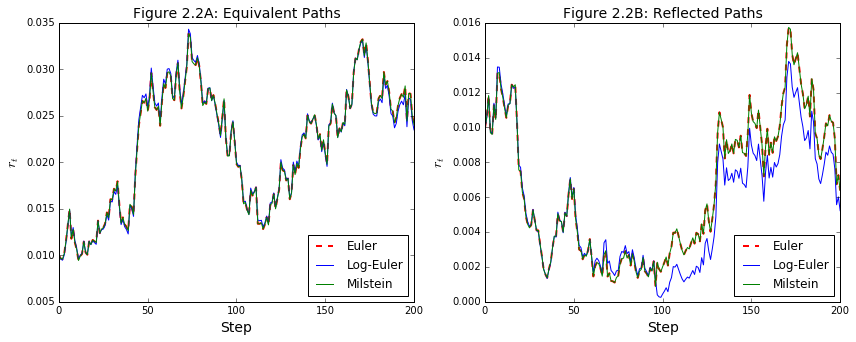

In [36]:
z = np.random.normal(size=[200,5000])
r_E, flag = CIR_Euler(k, r_bar, sigma, r0, T, eps=z)
r_L = CIR_LogEuler(k, r_bar, sigma, r0, T, eps=z)
r_M = CIR_Milstein(k, r_bar, sigma, r0, T, eps=z)

equiv = np.nonzero(flag==0)
eq = equiv[0][0]
reflected = np.nonzero(flag==1)
ref = reflected[0][0]

plt.figure(figsize=[14,5])
plt.subplot(1,2,1)

plt.plot(r_E[:,eq],'r--',LineWidth=2)
plt.plot(r_L[:,eq])
plt.plot(r_M[:,eq])
plt.xlabel('Step', fontsize=14)
plt.ylabel('$r_t$', fontsize=14)
plt.title('Figure 2.2A: Equivalent Paths', fontsize=14)
plt.legend(['Euler','Log-Euler','Milstein'], loc='best')

plt.subplot(1,2,2)
plt.plot(r_E[:,ref],'r--',LineWidth=2)
plt.plot(r_L[:,ref])
plt.plot(r_M[:,ref])
plt.xlabel('Step', fontsize=14)
plt.ylabel('$r_t$', fontsize=14)
plt.title('Figure 2.2B: Reflected Paths', fontsize=14)
plt.legend(['Euler','Log-Euler','Milstein'], loc='best')
plt.show()

## Problem 3

Consider two dimensional OU processes:

$$\begin{array} {l}
d x(t) &= \kappa_x (\mu_x - x(t)) dt + \sigma_x dw_x(t) \\
d y(t) &= \kappa_y (\mu_y - y(t)) dt + \sigma_y dw_y(t) \\
\end{array}$$

with the following parameterization: 

In [8]:
kx, ux, volx = .5, .05, .05
ky, uy, voly = .1, .02, .01
rho_xy = .5 # correlation between dw_x and dw_y
x0, y0 = .01, .01

1. simulate the correlated process to 1Y using Euler discretization, using 100 time steps, i.e., $dt = 0.01$. Estimate the correlation between the final values of $x(t=1Y), y(t=1Y)$. Is the simulated correlation the same as the correlation between $dw_x, dw_y$? 
2. [optional] derive the analytical formula for the correlation between the terminal value of $x(t)$ and $y(t)$, and verify it with the numerical simulation results.

### Solution

**1)** To simulate two correlated OU processes, we can first generate two correlated normal random variables as follows:

$$ \left( \begin{array} \\ z_1 \\ z_2 \end{array} \right) = \left( \begin{matrix}  1 & 0 \\ \rho & \sqrt{1-\rho^2} \end{matrix} \right) \left( \begin{array} \\ \epsilon_1 \\ \epsilon_2 \end{array} \right)$$

where $\rho$ is the correlation between $z_1$ and $z_2$, and $\epsilon_1$ and $\epsilon_2$ are two independent standard normal random variables of the same length. Then the correlation between $dw_x$ and $dw_y$ is also $\rho$, as scaling of $z_1, z_2$ by $\sqrt{\delta t}$ does not change their correlation.

In [9]:
kx, ux, volx = .5, .05, .05
ky, uy, voly = .1, .02, .01
rho_xy = .5 # correlation between dw_x and dw_y
x0, y0 = .01, .01
dt = 0.01
T = 1.
N = 100
M = 100000

z1 = np.random.normal(size=[N,M])
z2 = rho_xy*z1 + np.sqrt(1-rho_xy**2)*np.random.normal(size=[N,M])

z1 = z1*np.sqrt(dt)
z2 = z2*np.sqrt(dt)

x = np.zeros([N+1,M])
x[0,:] = x0
y = np.zeros([N+1,M])
y[0,:] = y0
for n in np.arange(1,N+1):
    x[n,:] = x[n-1,:] + kx*(np.tile(ux,(1,M))-x[n-1,:])*dt + volx*x[n-1,:]*z1[n-1,:]
    y[n,:] = y[n-1,:] + ky*(np.tile(uy,(1,M))-y[n-1,:])*dt + voly*y[n-1,:]*z2[n-1,:]


corr = np.corrcoef(x[-1,:],y[-1,:])[0,1]
print("The simulated correlation between x(1Y) and y(1Y) is %.3f" % corr)

The simulated correlation between x(1Y) and y(1Y) is 0.481


**2)** The analytical solution to the OU process is:

$$\small x(t) = x(t_0)e^{-\kappa (t-t_0)} + \bar x (1 - e^{-\kappa (t-t_0)}) + \int_{t_0}^t\sigma e^{-\kappa(t-u)}dw(u)$$

Let $t_0 = 0$, the formula for calculating the correlation between the terminal values of $x(t)$ and $y(t)$ can be obtained as:

$$\begin{align}
\text{corr}\left( x(t), y(t) \right) &= \frac{\text{cov}\left( x(t), y(t) \right)}{\sqrt {Var[x(t)]Var[y(t)]}} \\
&= \frac{\mathbb E\left[ (x(t) -\mathbb E(x(t)) (y(t) - \mathbb E(y(t)) \right] }{\sqrt{Var[x(t)]Var[y(t)]}} \\
&= \frac{\mathbb E\left[ \sigma_x\sigma_y \int_0^t e^{- \kappa_x (t-u)- \kappa_y (t-u)}dw_x(u)dw_y(u) \right] } {\sqrt{\mathbb E\left[ \left( \sigma_x \int_0^t e^{- \kappa_x (t-u)}dw_x(u)\right)^2 \right] \mathbb E\left[ \left( \sigma_y \int_0^t e^{- \kappa_y (t-u)}dw_y(u) \right)^2 \right]}} \\
&= \frac{\sigma_x\sigma_y \rho_{xy} \int_0^t e^{- \kappa_x (t-u)- \kappa_y (t-u)} du} {\sqrt{\sigma_x^2\int_0^t e^{- 2\kappa_x (t-u)}du ~\sigma_y^2\int_0^t e^{- 2\kappa_y (t-u)}du }}  \\
&= \rho_{xy} \frac{\int_0^t e^{- \kappa_x (t-u)- \kappa_y (t-u)} du} {\sqrt{\int_0^t e^{- 2\kappa_x (t-u)}du ~\int_0^t e^{- 2\kappa_y (t-u)}du }} \\
&= \frac{2 \sqrt{\kappa_x \kappa_y}}{\kappa_x+\kappa_y} \frac{1-e^{-(\kappa_x+\kappa_y) t}}{\sqrt{(1-e^{-2\kappa_x t})(1-e^{-2\kappa_y t})}} \cdot \rho_{xy}
\end{align} $$

As seen above, the analytical correlation depends on $\kappa_x$ and $\kappa_y$, too. 

In [10]:
corr_a = 2*np.sqrt(kx*ky)/(kx+ky)*(1-np.exp(-(kx+ky)*T))/np.sqrt((1-np.exp(-2*kx*T))*(1-np.exp(-2*ky*T)))*rho_xy
print("The theoretical correlation between x(1Y) and y(1Y) is %.3f" % corr_a)

The theoretical correlation between x(1Y) and y(1Y) is 0.497


## (Extra Credit) Problem 4

Price a American call option using LSMC, assuming:
* initial stock price and option strikes: $s(0) = k = 100$
* continuounsly compounded discount rate $r = 0.02$
* continuous dividend yield is $y = 0.1$
* stock volatility $\sigma = 0.25$
* option expiry: $t = 1Y$

You need to produce the following output:
1. European and American option prices
2. Exercise boundary

For this exercise, obviously you should not use the mc package provided as part of the lecture, you need to implement you own Americal LSMC pricer.

### Solution

In [11]:
t, m, r, y, s0, k, vol = 1., 52, .02, .1, 100, 100, .25

dt = t/m 
n = 100000

ts = np.arange(1, m+1)*dt

gbm = proc.GBM(r-y, vol)
spath = gbm.draw(np.random.normal(size=[n, m]), s0, dt)

ecall = np.maximum(spath[:,-1]-k, 0)*np.exp(-r*t)
u = np.mean(ecall)
e = np.std(ecall)/sqrt(n)

print "European call price is %.2f, MC err %.2g" % (u, e) 

NameError: name 'proc' is not defined

In [ ]:
import mc

call_ev = lambda x : np.maximum(x - k, 0)
v_b, e_b, b_b, cvs = mc.amer_opt(spath, exp(-r*dt), call_ev, mc.fit_ex)

print "American put value from LSMC is %.3f" % v_b

In [ ]:
plot(ts, b_b + k, '.-');
xlabel('Time(t)')
title('Exercise Boundary for American Call');